In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import os
import sys
import time
import datetime


In [10]:
HISTORY_FILE = 'trading_records.csv'

# read the data
df = pd.read_csv(HISTORY_FILE)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# del the rows with price 0
df = df[df['Price'] != 0]

# add transaction ID column
df['Transaction_ID'] = range(len(df))


In [11]:
df.head()

,Timestamp,Action,Price,CA,Transaction_ID
0,2025-02-12 00:14:13,BUY,0.00067,F14hCmEKjcaXobNE2fMdRX9EcetC2oNuiZVjpce1iohE,0
1,2025-02-12 00:15:31,SELL,0.00025,AL7R5U91pmA67Pf4pUBVUsLgADZa9F2JdYUYnfjApump,1
2,2025-02-12 00:15:50,BUY,0.00076,F14hCmEKjcaXobNE2fMdRX9EcetC2oNuiZVjpce1iohE,2
3,2025-02-12 00:16:42,SELL,0.00089,F14hCmEKjcaXobNE2fMdRX9EcetC2oNuiZVjpce1iohE,3
4,2025-02-12 00:21:41,BUY,0.00059,F14hCmEKjcaXobNE2fMdRX9EcetC2oNuiZVjpce1iohE,4


In [12]:
# simple backtest
initial_balance = 1000
num_coins_per_trade = 10000 # 10000 is the number of coins to buy or sell

# 创建资产组合跟踪数据框
portfolio = pd.DataFrame(columns=['Timestamp', 'Balance', 'Coins', 'Coin_Value', 'Total_Value'])
current_balance = initial_balance
current_coins = 0


# 创建资产组合跟踪数据框
portfolio = {
    'balance': initial_balance,
    'holdings': {},  # 用字典存储不同币种的持仓信息
    'blacklist': [] #10x coins, nvr buy again
}

# 创建交易历史记录数据框
trade_history = pd.DataFrame(columns=[
    'Timestamp', 
    'Balance', 
    'Action', 
    'CA',
    'Coin_Amount',
    'Price',
    'Trade_Value',
    'Total_Value'
])

def update_portfolio(timestamp, ca, action, amount, price):
    """更新资产组合状态"""
    if action == 'BUY':
        if ca in portfolio['blacklist']:
            return
        cost = amount * price
        if cost <= portfolio['balance']:
            portfolio['balance'] -= cost
            # 如果是新币种，初始化持仓
            if ca not in portfolio['holdings']:
                portfolio['holdings'][ca] = {
                    'amount': amount,
                    'avg_price': price
                }
            else: # if the coin is already in the portfolio
                avg_price = (portfolio['holdings'][ca]['avg_price']*portfolio['holdings'][ca]['amount'] + price*amount)/(portfolio['holdings'][ca]['amount'] + amount)
                portfolio['holdings'][ca]['avg_price'] = avg_price
                portfolio['holdings'][ca]['amount'] += amount
        
    elif action == 'SELL':
        if ca not in portfolio['holdings']:
            pass

        else:
            # if the sell price is 10x than avg price, sell all the holdings of the coin. and put it in the blacklist
            if price >= 10 * portfolio['holdings'][ca]['avg_price']:
                portfolio['balance'] += portfolio['holdings'][ca]['amount'] * price
                del portfolio['holdings'][ca]
                portfolio['blacklist'].append(ca)
                return True
            else:
                if portfolio['holdings'][ca]['amount'] >= amount:
                    portfolio['balance'] += amount * price
                    portfolio['holdings'][ca]['amount'] -= amount
                else:
                    portfolio['balance'] += portfolio['holdings'][ca]['amount'] * price
                    del portfolio['holdings'][ca]
        


def calculate_total_value(current_prices):
    """计算当前总资产价值"""
    total_value = portfolio['balance']
    for ca, holding in portfolio['holdings'].items():
        if ca in current_prices:
            coin_value = holding['amount'] * current_prices[ca]
            total_value += coin_value
    return total_value


In [13]:
# 遍历每笔交易
for index, row in df.iterrows():
    ca = row['CA']
    action = row['Action']
    amount = num_coins_per_trade
    price = row['Price']
    
    # 更新资产组合
    blacklist_flag = update_portfolio(row['Timestamp'], ca, action, amount, price)
    # 获取当前所有持仓币种的最新价格
    current_prices = {ca: price}
    # print(current_prices)
    total_value = calculate_total_value(current_prices)
    # print(ca)
    # 记录交易历史
    trade_history.loc[len(trade_history)] = {
        'Timestamp': row['Timestamp'],
        'Balance': portfolio['balance'],
        'Action': action,
        'CA': str(ca),
        'Coin_Amount': amount,
        'Price': price,
        'Trade_Value': amount * price,
        'Total_Value': total_value,
        'Blacklist_Flag': blacklist_flag
    }


In [14]:
trade_history['Total_Value'].argmax()
# print the row of the max total value
trade_history.iloc[trade_history['Total_Value'].argmax()]


Timestamp                               2025-02-12 04:32:31
Balance                                               799.0
Action                                                  BUY
CA             3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y
Coin_Amount                                           10000
Price                                               1.43849
Trade_Value                                         14384.9
Total_Value                                         15183.9
Name: 208, dtype: object

In [15]:
print('Final Value: ', total_value)

Final Value:  124.8999999999997


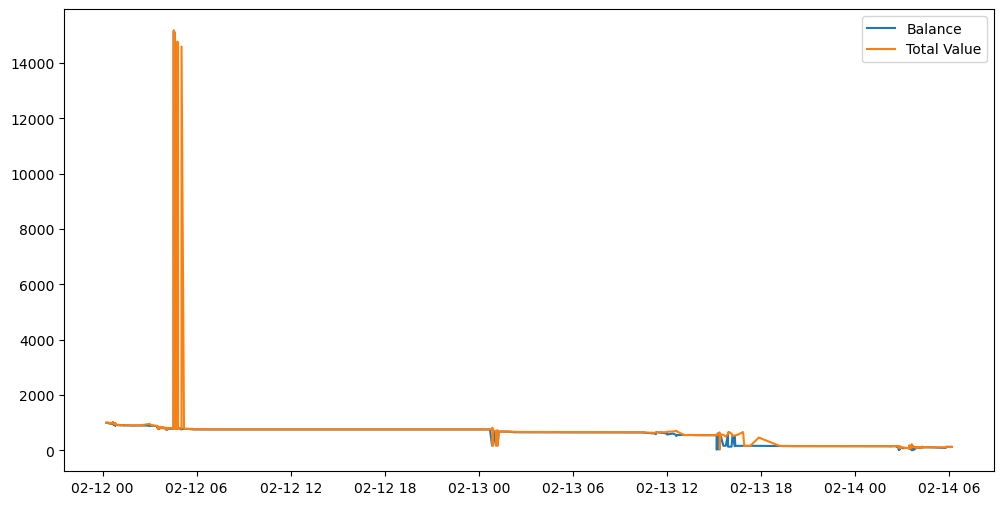

In [16]:
# draw the history of transaction
plt.figure(figsize=(12, 6))
plt.plot(trade_history['Timestamp'], trade_history['Balance'], label='Balance')
plt.plot(trade_history['Timestamp'], trade_history['Total_Value'], label='Total Value')
plt.legend()
plt.show()


In [17]:
portfolio['blacklist']   

['KFTSxPQxDV1wGjEvzKHWD7mG6e9TsMVq4eF4mQppump',
 'B8pn5VTcQ7MFjnpTbz5utiYZswz6BL6wPkujnQMbCoU8']

In [22]:
df[df['CA'] == '3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y']

# df[(df['Transaction_ID'] > 190) & (df['Transaction_ID'] < 210)]


,Timestamp,Action,Price,CA,Transaction_ID
167,2025-02-12 03:42:36,SELL,1.37470,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,152
190,2025-02-12 03:58:12,BUY,1.37484,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,175
191,2025-02-12 03:58:33,BUY,1.35146,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,176
213,2025-02-12 04:28:28,BUY,1.42392,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,198
214,2025-02-12 04:28:44,BUY,1.42292,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,199
215,2025-02-12 04:29:06,BUY,1.40003,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,200
222,2025-02-12 04:32:21,BUY,1.43676,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,207
223,2025-02-12 04:32:31,BUY,1.43849,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,208
225,2025-02-12 04:35:36,BUY,1.43201,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,210
236,2025-02-12 04:46:23,BUY,1.39999,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,221


In [25]:
# check all transactions of certain coin
target_CA = '3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y'
df[df['CA'] == target_CA]
# df[(df['Transaction_ID'] > 190) & (df['Transaction_ID'] < 210)]

,Timestamp,Action,Price,CA,Transaction_ID
167,2025-02-12 03:42:36,SELL,1.37470,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,152
190,2025-02-12 03:58:12,BUY,1.37484,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,175
191,2025-02-12 03:58:33,BUY,1.35146,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,176
213,2025-02-12 04:28:28,BUY,1.42392,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,198
214,2025-02-12 04:28:44,BUY,1.42292,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,199
215,2025-02-12 04:29:06,BUY,1.40003,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,200
222,2025-02-12 04:32:21,BUY,1.43676,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,207
223,2025-02-12 04:32:31,BUY,1.43849,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,208
225,2025-02-12 04:35:36,BUY,1.43201,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,210
236,2025-02-12 04:46:23,BUY,1.39999,3iQL8BFS2vE7mww4ehAqQHAsbmRNCrPxizWAT2Zfyr9y,221
